# Chapter 12 - Custom Models and Training with TensorFlow


Keras is TF's high level API - and already got us really far. Good enough for 95% of users.


# Quick tour of TensorFlow

What does it offer:
- similar core to numpy, with GPU support
- supports distributed computing
- just-in-time to optimize computation for speed/memory usage - extracting the computation graph from a python function, then optimizing it
- can train a TF model in one environment and run in another
- implements autodiff - with great optimizers like RMSProp, nadam, ftrl, etc
- most import is tf.keras - but also data loading & preprocessing ops (tf.data, tf.io), image processing ops (tf.image), signal processing ops (tf.signal), and more.


<div>
    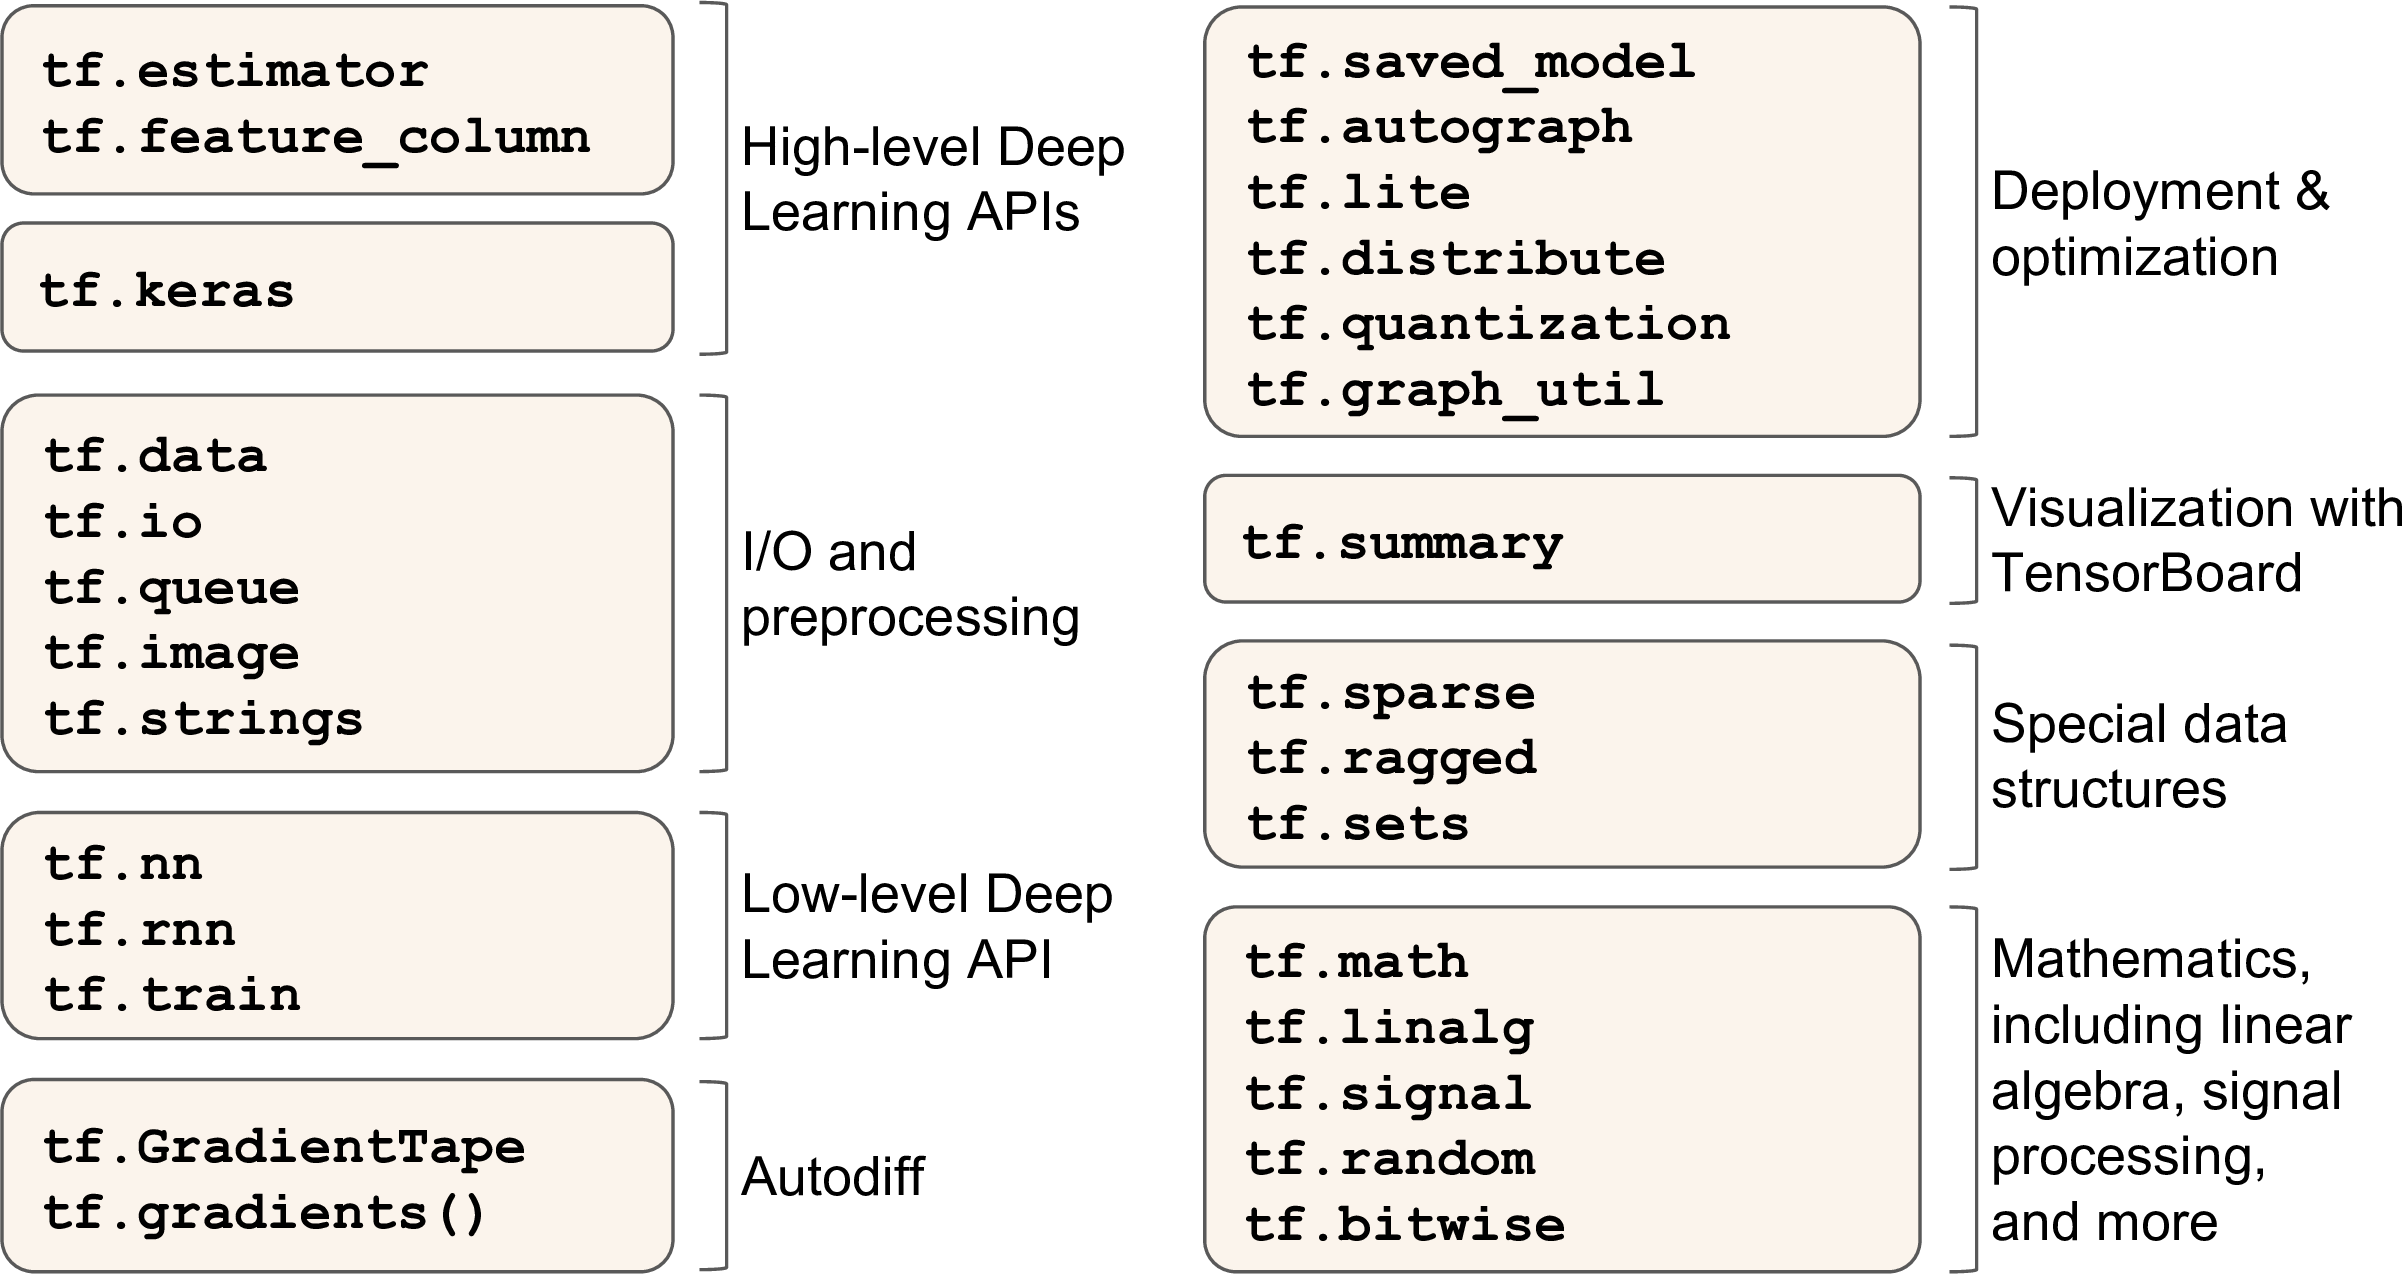
</div>


At low level, it uses highly efficient C++. Operations (ops) have implementations called kernels - kernel is dedicated to device types - CPUs, GPUs, or TPUs (Tensor Processing Units), etc. GPUs can speed up computation by splitting it into many smaller chunks and running in parallel across GPU threats. TPUs are even faster.

Can purchase own GPU devices, or TPUs from Google Cloud Machine Learning Engine.

Tensorflow Architecture:

<div>
    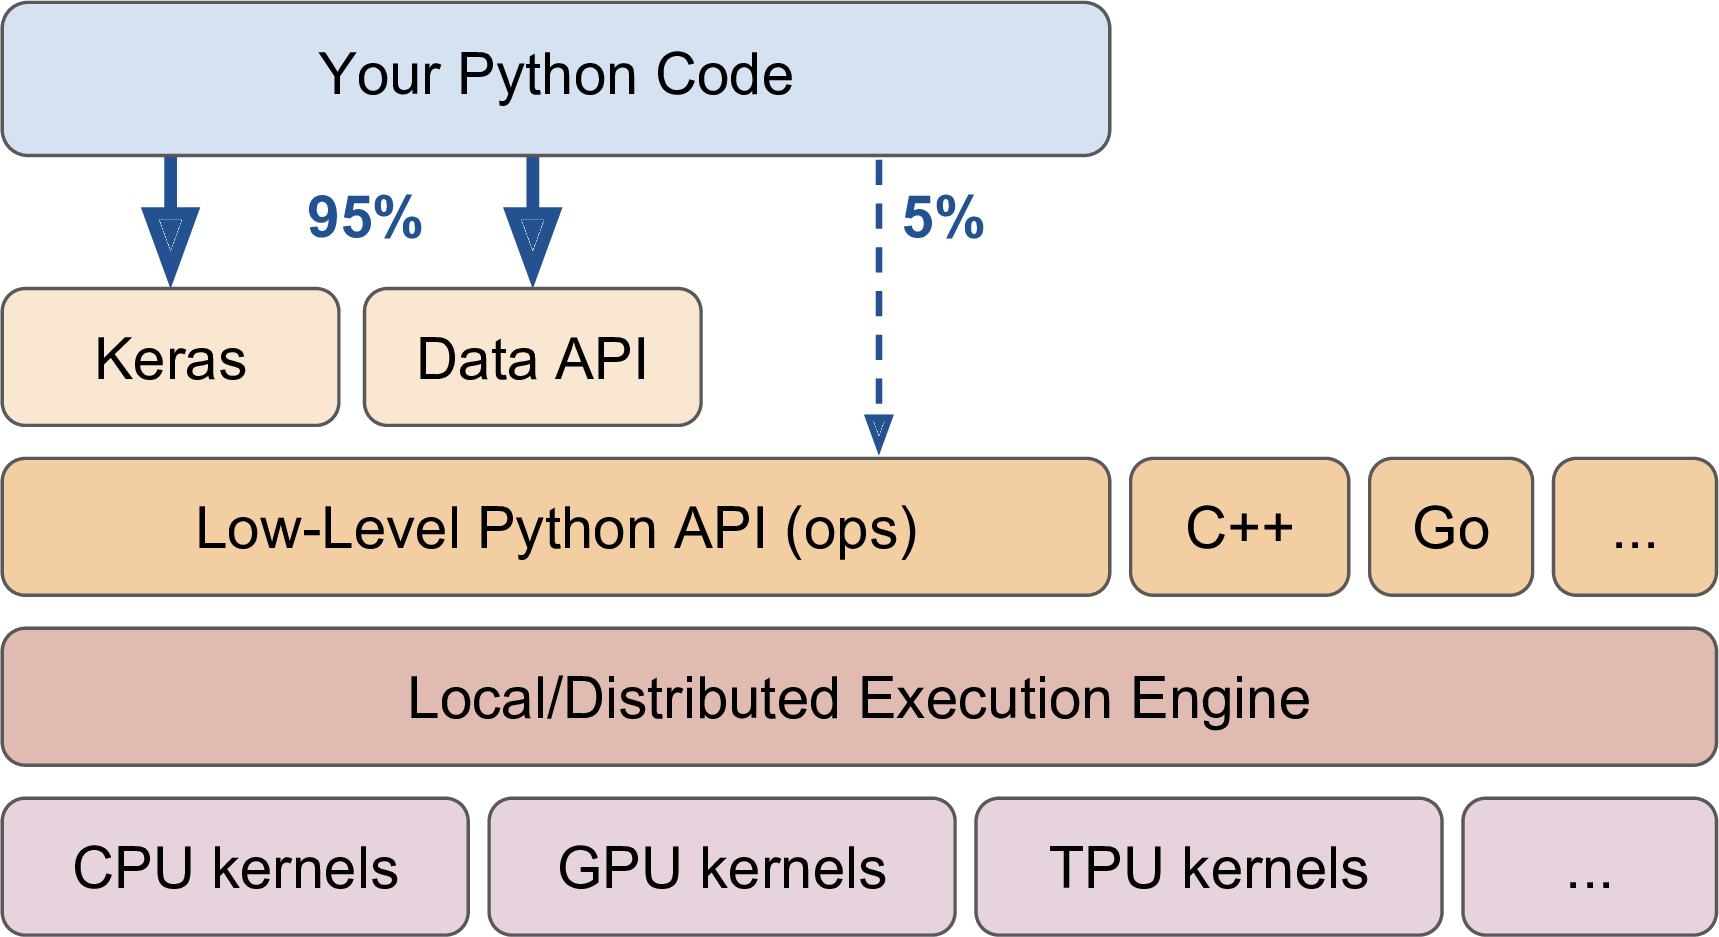
</div>


Can use on mobile or with Javascript.


Also more to it than library - centre of ecosystem of libraries. TensorBoard for visualization, TFX to productionize TensorFlow projects, TensorFlow Hub, etcetc. Always easiler to find existing code on GitHub.https://paperswithcode.com is good site.

In [1]:
%autosave 120

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(24)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Autosaving every 120 seconds


# Using TensorFlow - like numpy

API revolves around tensors - multidimensional array (like numpy ndarray), but can also hold scalar (a simple value like 24). 

## Operations

In [2]:
tf.constant([[1., 2., 3.], [4., 5., 6.]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
tf.constant(24)

<tf.Tensor: shape=(), dtype=int32, numpy=24>

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t.shape, t.dtype

(TensorShape([2, 3]), tf.float32)

In [5]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [6]:
t @ tf.transpose(t) # @ is for matrix multiplication - same as tf.matmul()

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

#### Keras low level API

Keras API has its own low-level API as well - in keras.backend. 

## Tensors and numpy

Can create tensor from numpy array, and vice versa - even apply TensorFlow operations to numpy arrays and numpy operation to tensors.

! - numpy uses 64 bit, but TF uses 32 bit - because 32 bit precision is generally enough for DNNs and uses a lot less RAM and faster. When creating tensor from numpy, use dtype = tf.float32

## Type Conversions

TF does not auto convert to avoid significantly hurting performance - it just raises exception if trying to operate on tensors with incompatible types. Can use tf.cast() to convert.


## Variables

Weights in DNN need to be tweaked by backpropagation, and other parameters may also change over time. So use tf.Variable:

In [7]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [8]:
# Updating

v.assign(2 * v)    # => [[2., 4., 6.], [8., 10., 12.]]
v[0, 1].assign(42) # => [[2., 42., 6.], [8., 10., 12.]]
v[:, 2].assign([0., 1.]) # => [[2., 42., 0.], [8., 10., 1.]]
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.]) # => [[100., 42., 0.], [8., 10., 200.]]

# In practice - rarely create variables manually. Keras has the add_weight() takes care of it.
# model parameters will be updated directly by the optimizer, so don't have to do it manually.

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

## Other data structures

- sparce tensors - efficient tensors containing mostly 0
- tensor arrays - lists of tensors
- ragged tensors - static lists of lists of tensors
- string tensors - tensors of tf.string - represent byte strings and not unicode
- sets - regulor tensors containing one or more sets
- queues - First In, First Out queues - prioritize some items



# Customizing Models and Training Algorithms

## Custom loss function

If want to train a regression model, but training set is a bit noisy. For starters, clean up the dataset by removing/fixing the outliers but not enough.

Mean squared error might penalize large erors too much and make model imprecise, mean absolute takes too long. We can then use Huber loss - and here implmenting it from scratch.

In [9]:
def huber_fn(y_true, y_pred):
    
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)


# model.compile(loss=huber_fn, optimizer="nadam")
# model.fit(X_train, y_train, [...])

# Vectorized implementation like above is recommended. Also, use only TF operations if want to use its graph features.
# Also better to return tensor containing one loss per instance

## Saving/Loading models with custom components

Saving usually works. For loading, however, need to provide a dictionary mapping the function name to the actual function

model = keras.model.load_model("my_model_with_a_custom_loss.h5",
                               custom_objects={"huber_fn": huber_fn})
                               
We can also create a function which creates a configured loss function (to change threshold):

In [10]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < 1
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold ** 2/2 # Changes threshold
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

model.compile(loss=create_huber(2.0), optimizer="nadam")

# Threshold will not be saved, however, so need to specify threshold value when loading model

model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": create_hubder(2.0)})

# Solve this by creating subclass of keras.losses.Loss, etcetcetcetcet
# Look into book for details

NameError: name 'model' is not defined

## Custom activation functions/initializers/regularizers/constraints

Most of the times just need to write simple function with appropirate inputs/outputs.

E.g. (equivalent to keras.activations.softplus or tf.nn.softplus)



In [ ]:
def my_softplus(z): # returns tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32): # equivalent to keras.initializers.glorot_normal
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights): # equivalent to keras.regularizers.l1(0.01)
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # equivalent to keras.constraints.nonneg() or tf.nn.relu
    return tf.where(weights < 0, tf.zeros_like(weights), weights)
    # Where takes (condition, x, y) and if condition true multiplies x and y
    
layer = keras.layers.Dense(30, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

Quick reminder:

- activation is applied to output of this layer and passed on
- this layer's weights are intiizlied using the initializer
- at each trainin step weights are passed to the regularization function to compute regularization loss
- constraint is called after each training step - replacing layer weights with constrained weights


## Custom Metrics

Losses are used by Gradient Descent to train a model - so much be differentiable. Cross-entropy loss, for example, cannot be interpreted by humans.

Metrics are used to evaluate a model, so easily interpretable, non-differentiable and can have 0 gradient everywhere.


## Custom Layers

Might want exotic layer, or a layer containing multiple other layers to save the repetition.

exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x)) - apply exponential function to inputs. Unweighted.

For a weighed layer, need to create subclass of keras.layers.Layer class

See book for overview.

Remember - sequential API only accepts single input/output layers, and multiple ones (concatenate) only work with functional and subclassing APIs. 


## Custom Models

Can build any models you want - even with loops and skip connections. 

Need ResidualBlock layer - containing 2 dense layers and an additional operation

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z
    
    
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)
        
    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1+3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

Models are actually subclasses of layers with additional functionalities

Clearer to distinguish the internal components of the model - so use Layer for layers and Model for models. We can almost build any model in a paper. 

## Losses / Metrics based on Model Internals 

For regularization/monitoring purposes, might want to define losses based on other parts ofthe model - eg. weights/activations of hidden layers.

Example - MLP with 5 hidden layers and using reconstruction loss - last hidden with another Dense on top trying to reconstruct the inputs, hence needs the input_shape.

Above techniques - will be sufficient for 99% of any model - with complex architectures, losses, metrics and so on.  is below.


## Computing Gradients using Autodiff

For a normal function, to compute gradients will be analytically finding the partial derivatives by hand. 

For neural networks with hundres of thousands of parameters, it's almost impossible. One solution is computign an approximation of each partial derivative by measuring how much the output changes when you tweak the parameter. 

<b>Important</b> - Autodiff has errors and is just very efficient to implement - mainly for testing. Reverse mode autodiff is the one we use. Backpropagation, then, is the special case of reverse mode autodiff being implemented in neural nets. Autograd is the name of the pytorch library using autodiff. https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf


E.g.

In [ ]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

w1, w2 = 5, 3

# Finding partial derivatives by hand would become 36, 10

# Approximation method
eps = 1e-6
print((f(w1 + eps, w2) - f(w1, w2)) / eps)
print((f(w1, w2+eps) - f(w1, w2)) / eps)

# Calling f too much times - impractical in large neural nets


# Autodiff

w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
    
gradients = tape.gradient(z, [w1, w2]) # Only call gradient once - it will be erased after it
gradients

tf.GradientTape will automatically record every operation involving a variable - then we ask the tape to compute the graidnets of the result z with regards to both w1 and w2. Result is generally accurate, and no matter how many variables, it will always be efficient. 


## Custom Training Loops

When fit() isn't flexible enough - eg. for wide and deep networks

Usually - fit is better. Although more confidence, it's longer and error prone. Hence, not read.


# TensorFlow functions + graphs

TF1 graphs were very central. TF2 there are still importnat but much easiler to use.

In [ ]:
def cube(x):
    return x**3

cube(tf.constant(2.0))

# Converting from python function to TF function - which works exactly the same way

tf_cube = tf.function(cube)

# Underthe hood, it analyzes the cube() computation and generates an equivalent computation graph.

# Using tf.function as a decorate
@tf.function
def tf_cube(x):
    return x**3

Typically, TF is much more efficient than the python code - especially for complex computations. To boost a python function can convert it to TF!

Also, when writing a custom function and using it in keras, Keras automatically converts it to a TF function. 


## Autograph and Tracing

How does tf generate graphs? It starts by analyzing the python function source code to capture control flow statmeents (loops, if, etc). This is called Autograph.

Python does not provide anyway to capture control flow arguments - only for add() or mul() but not for while() or if(), etc. 

Then, autograph outputs an upgraded version replacing python with TF functions

Example:

<br>
<div>
    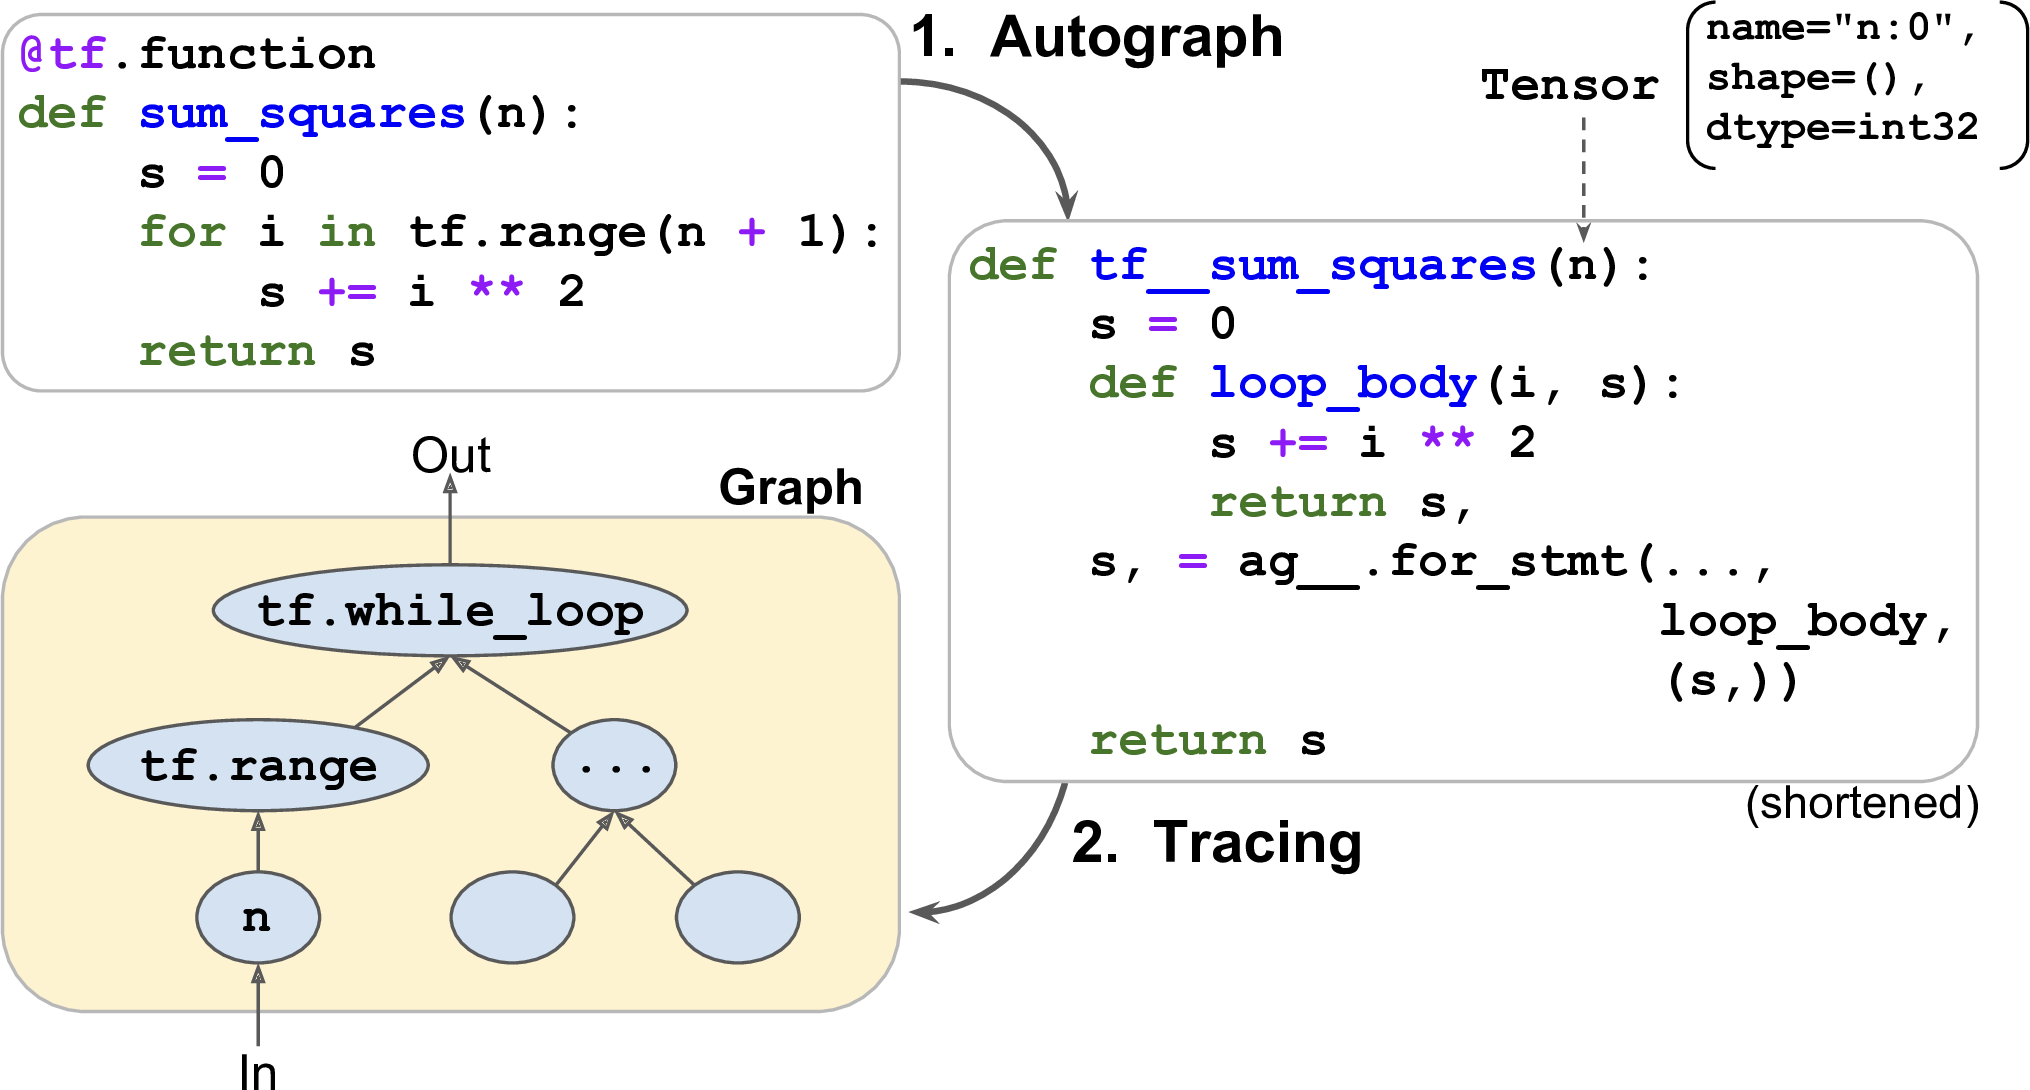
</div>

Next, TF calls this upgraded function, passing a symbolic tensor (valueless). Function will run in graph mode - each TF operation will add a node in the graph to represent itself and output tensors. (instead of normal mode - eager execution). In graph mode TF operations do not perform computations. 

In graph above ellipses represent operations and arrows represent tensors. 


## TF Function Rules

Few rules for conversion between python + TF:

- When calling external library (even numpy) - if will only be during tracing and not part of the graph. Use tf.reduce_sum, etc. Wrapping python code in tf.py_function is not good - does not optimize.
- Call other python/TF functions, but follow the same rules
- If function creates TF variable - must be on the first call - usually create variables outside
- Python function source code must be available to TF
- TF only captures for loops when iterating over tensor or dataset. So instead of for i in range use for i in tf.range. 
- Vectorized implementation and not using loops